<a href="https://colab.research.google.com/github/akshataxx/Fuel-Price-Prediction/blob/main/Fuel_Price_RNN_LSTM_bidirectional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Bidirectional
from keras.layers import Activation
from keras.layers import Dropout
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import keras
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
# warnings.filterwarnings("ignore")
# plt.style.use('fivethirtyeight')
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
import h5py
import requests

In [4]:
df = pd.read_csv(r'./Datasets.csv')
df.head()


,Date,Brent Price,Petrol Price,Diesel Price,Covid Case numbers
0,2/1/2020,96.484950,145.5289,143.01,0
1,4/1/2020,99.406120,127.0100,129.67,0
2,7/1/2020,101.089750,123.5888,115.64,0
3,25/1/2020,89.206812,111.4470,143.61,3
4,26/1/2020,86.410908,111.5013,147.74,3


In [ ]:
def shape(dataframe):
    print('='*20,'DATAFRAME SHAPE','='*20)
    print('Dataframe has {} rows and {} columns'.format(dataframe.shape[0],dataframe.shape[1]))
    print('\n')

def info(dataframe):
    print('='*20,'Dataframe Info','='*20)
    display(dataframe.info())
    print('\n')
    
def describe(dataframe):
    print('='*20,'Dataframe Describe','='*20)
    display(dataframe.describe().T)
    print('\n')
    
def missing_unique_values(dataframe):
    missing = pd.DataFrame({'Name':dataframe.columns,
                            'Unique':[dataframe[col].nunique() for col in df.columns],
                            'Missing': [dataframe[col].isna().sum() for col in dataframe.columns]})
    missing = missing.sort_values(by='Missing',ascending=False).reset_index(drop=True)
    return missing

shape(df)
info(df)
describe(df)
missing_unique_values(df)

==================== DATAFRAME SHAPE ====================
Dataframe has 212 rows and 4 columns


==================== Dataframe Info ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 212 non-null    object 
 1   Brent Price          212 non-null    float64
 2   Petrol Price         212 non-null    float64
 3   Covid Case numbers   212 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.8+ KB


None



==================== Dataframe Describe ====================


,count,mean,std,min,25%,50%,75%,max
Brent Price,212.0,41.050472,12.836305,9.12,34.775,41.585,45.12,70.25
Petrol Price,212.0,91.050472,12.836305,59.12,84.775,91.585,95.12,120.25
Covid Case numbers,212.0,7103.853774,6400.874459,4.00,538.750,6932.000,7939.25,24622.00


,Name,Unique,Missing
0,Date,212,0
1,Brent Price,206,0
2,Petrol Price,206,0
3,Covid Case numbers,188,0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df.set_index('Date',inplace=True)

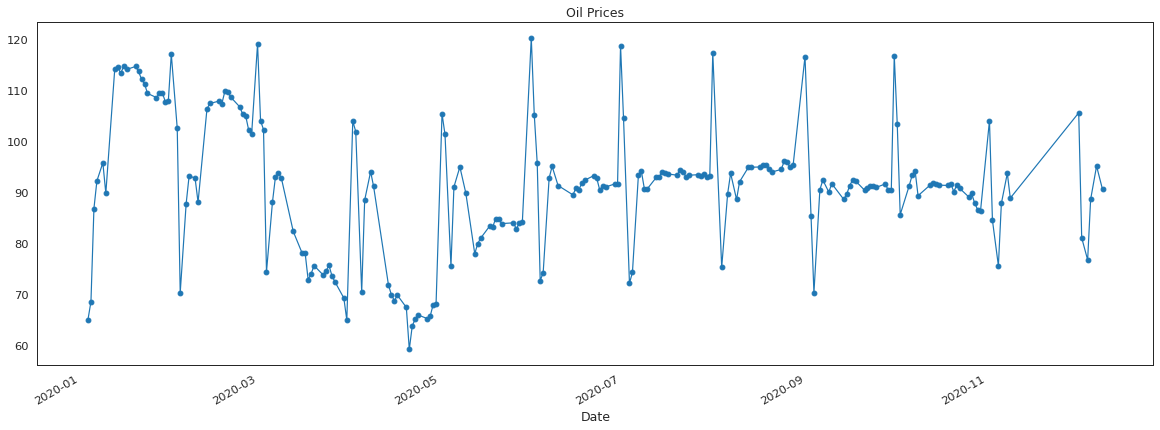

In [ ]:
df['Petrol Price'].plot(title='Petrol Prices',marker='o',figsize=(20,7))

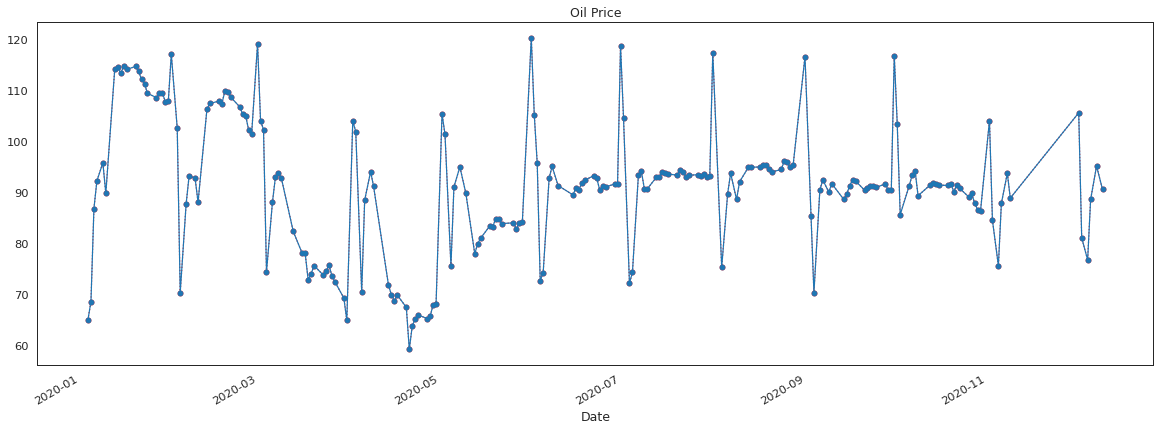

In [ ]:
bfill_imp = df.fillna(method='bfill')
bfill_imp['Petrol Price'].plot(color='red', marker='o', linestyle='dotted')
df['Petrol Price'].plot(title='Petrol Price', marker='o',figsize=(20,7))

In [ ]:
df = df.fillna(method = 'bfill')
df = df.reset_index()
df = df.sort_values('Date')
df.set_index('Date',inplace=True, drop =True)

In [ ]:
rng = pd.date_range(start = '2020-01-04', end = '2020-11-20', freq='D')

In [ ]:
df.index

DatetimeIndex(['2020-01-04', '2020-01-05', '2020-01-06', '2020-01-07',
               '2020-01-09', '2020-01-10', '2020-01-13', '2020-01-14',
               '2020-01-15', '2020-01-16',
               ...
               '2020-11-05', '2020-11-06', '2020-11-08', '2020-11-09',
               '2020-12-02', '2020-12-03', '2020-12-05', '2020-12-06',
               '2020-12-08', '2020-12-10'],
              dtype='datetime64[ns]', name='Date', length=212, freq=None)

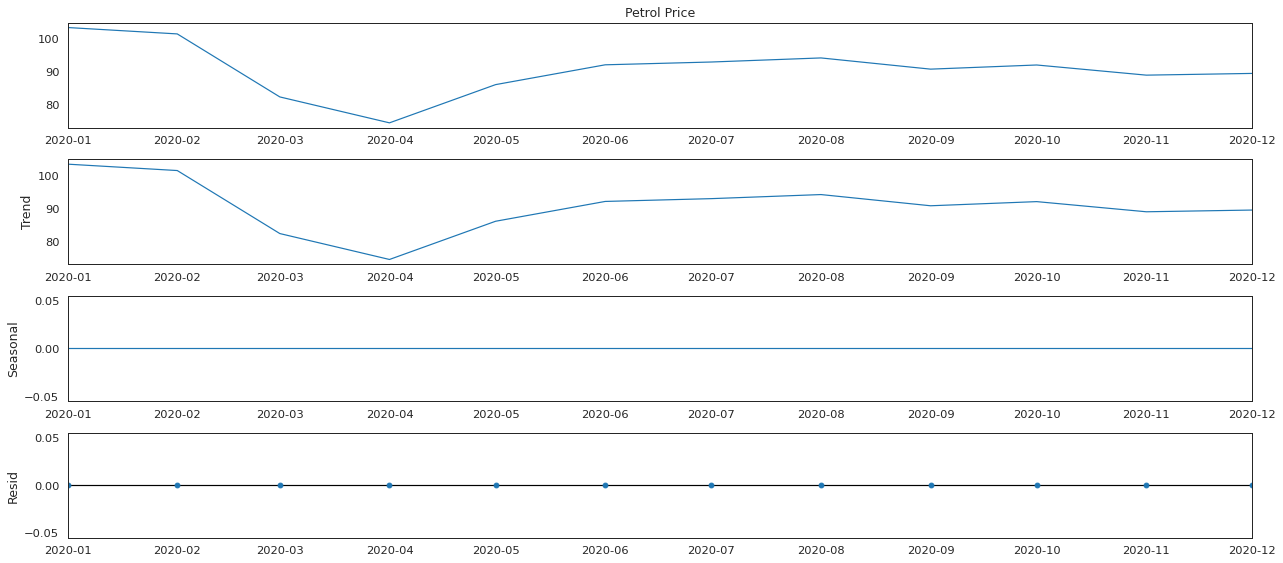

In [ ]:
y = df['Petrol Price'].resample('MS').mean()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq', period=1)
# plt.rcParams.update({'figure.figsize': (5,5)})
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()
# )
fig = decomposition.plot()
plt.show()


In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df['Petrol Price'].values.reshape(-1, 1))
df[0:10]

array([[0.09569769],
       [0.1532799 ],
       [0.45182398],
       [0.54081466],
       [0.59872403],
       [0.50106331],
       [0.90004908],
       [0.90512024],
       [0.88614428],
       [0.90806478]])

In [ ]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size

train, test = df[0:train_size,:], df[train_size:len(df),:]

train.shape

(148, 1)

In [ ]:
test.shape

(64, 1)

In [ ]:
f'Dataset size: {len(df)} >> Train length: {len(train)} || Test Length: {len(test)}'

'Dataset size: 212 >> Train length: 148 || Test Length: 64'

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back-1):
                a = dataset[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)


f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
Y_test: {y_test.shape}'

'X_train: (132, 15) || y_train: (132,) || X_test: (48, 15) || Y_test: (48,)'

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
f'X_train: {x_train.shape} || \
y_train: {y_train.shape} || \
X_test: {x_test.shape} || \
y_test: {y_test.shape}'

'X_train: (132, 1, 15) || y_train: (132,) || X_test: (48, 1, 15) || y_test: (48,)'

In [ ]:
look_back = 15
model = Sequential()
model.add(RNN(LSTM(100, activation='relu', input_shape=(100,1))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(x_train, y_train, epochs=200, batch_size=5, verbose=2)

Epoch 1/200
27/27 - 3s - loss: 0.0848 - 3s/epoch - 123ms/step
Epoch 2/200
27/27 - 0s - loss: 0.0407 - 100ms/epoch - 4ms/step
Epoch 3/200
27/27 - 0s - loss: 0.0373 - 105ms/epoch - 4ms/step
Epoch 4/200
27/27 - 0s - loss: 0.0339 - 88ms/epoch - 3ms/step
Epoch 5/200
27/27 - 0s - loss: 0.0314 - 123ms/epoch - 5ms/step
Epoch 6/200
27/27 - 0s - loss: 0.0319 - 87ms/epoch - 3ms/step
Epoch 7/200
27/27 - 0s - loss: 0.0312 - 94ms/epoch - 3ms/step
Epoch 8/200
27/27 - 0s - loss: 0.0286 - 92ms/epoch - 3ms/step
Epoch 9/200
27/27 - 0s - loss: 0.0279 - 100ms/epoch - 4ms/step
Epoch 10/200
27/27 - 0s - loss: 0.0279 - 96ms/epoch - 4ms/step
Epoch 11/200
27/27 - 0s - loss: 0.0294 - 92ms/epoch - 3ms/step
Epoch 12/200
27/27 - 0s - loss: 0.0301 - 104ms/epoch - 4ms/step
Epoch 13/200
27/27 - 0s - loss: 0.0284 - 94ms/epoch - 3ms/step
Epoch 14/200
27/27 - 0s - loss: 0.0266 - 89ms/epoch - 3ms/step
Epoch 15/200
27/27 - 0s - loss: 0.0284 - 102ms/epoch - 4ms/step
Epoch 16/200
27/27 - 0s - loss: 0.0253 - 93ms/epoch - 3ms/

In [ ]:
monitor = EarlyStopping(monitor = 'loss', min_delta=1e-3, patience=30,
                       verbose=1,mode='auto',restore_best_weights=True)

history1=model.fit(x_train,y_train,
        callbacks=[monitor],verbose=1,epochs=100 )

Epoch 1/100
5/5 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 4/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 5/100
5/5 [==============================] - 0s 4ms/step - loss: 0.0084
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 0.0079
Epoch 8/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 9/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 10/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 11/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 12/100
5/5 [==============================] - 0s 5ms/step - loss: 0.0084
Epoch 13/100
5/5 [==============================] - 0s 5ms/st

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              92800     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 93,001
Trainable params: 93,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

2/2 [==============================] - 0s 10ms/step
Train Score: 5.67 RMSE
Test Score: 8.44 RMSE


# New Section

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Root Mean Squared Error:',math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Root Mean Squared Error:',math.sqrt(mean_squared_error(testY[0], testPredict[:,0])))

Train Mean Absolute Error: 3.6014986361879293
Train Root Mean Squared Error: 5.66825720038553
Test Mean Absolute Error: 7.035442218780517
Test Root Mean Squared Error: 8.44111138036822


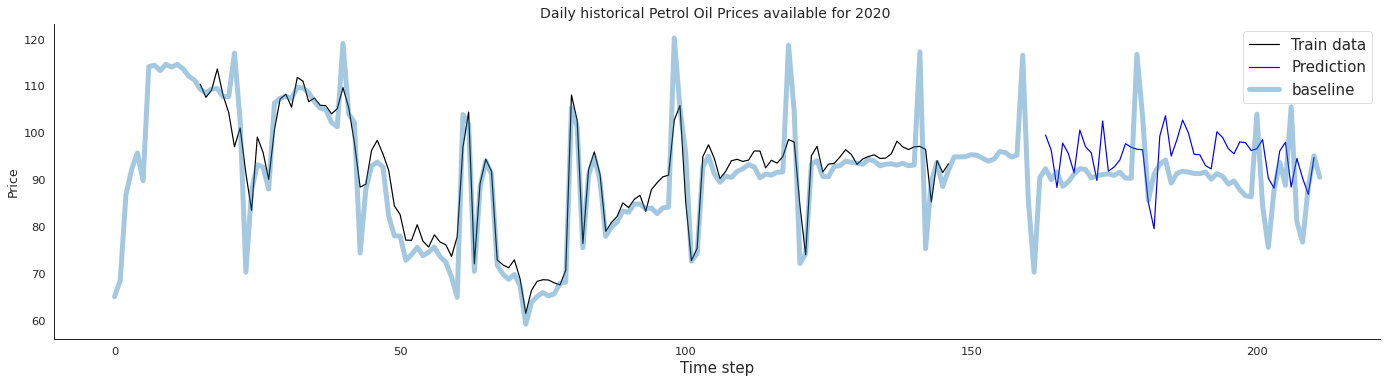

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions

plt.figure(figsize=(20,5))
plt.plot(trainPredictPlot, color='black', label='Train data')
plt.plot(testPredictPlot, color='blue', label='Prediction',)
plt.plot(scaler.inverse_transform(df),label='baseline', alpha=0.4, linewidth=5)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.title('Daily historical Petrol Oil Prices available for 2020 ', fontsize=14)
plt.ylabel('Price')
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()